In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Data Directories
# Where KITTI data will be saved if you run process_kitti.py
# If you directly download the processed data, change to the path of the data.
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/PredNet replication/kitti_data'

# Where model weights and config will be saved if you run kitti_train.py
# If you directly download the trained weights, change to appropriate path.
WEIGHTS_DIR = '/content/drive/MyDrive/Colab Notebooks/PredNet replication/model_data_keras2/'

# Where results (prediction plots and evaluation file) will be saved.
RESULTS_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/PredNet replication/kitti_results/'

In [ ]:
# @title Sequence Generator
# Necessary imports for handling data and keras utilities
import tensorflow as tf
import h5py
import pickle
import numpy as np
from tensorflow.keras.utils import Sequence

class SequenceGenerator(Sequence):
    # Initialization of the generator
    def __init__(self, data_file, source_file, nt, batch_size=8, shuffle=False, seed=None,
                 output_mode='error', sequence_start_mode='all', N_seq=None):
        # Open the data file and load the data
        with h5py.File(data_file, 'r') as f:
            key = list(f.keys())[0]
            self.X = f[key][:]
        # Open the source file and load the sources (e.g., video indices or identifiers)
        with h5py.File(source_file, 'r') as f:
            key = list(f.keys())[0]
            self.sources = f[key][:]

        # Set various parameters for data generation
        self.nt = nt  # Number of timesteps per sequence
        self.batch_size = batch_size
        # Ensure valid sequence_start_mode and output_mode values
        assert sequence_start_mode in {'all', 'unique'}, 'sequence_start_mode must be in {all, unique}'
        assert output_mode in {'error', 'prediction'}, 'output_mode must be in {error, prediction}'
        self.sequence_start_mode = sequence_start_mode
        self.output_mode = output_mode

        self.im_shape = self.X[0].shape  # Image shape

        # Determine possible start indices for sequences
        if self.sequence_start_mode == 'all':
            self.possible_starts = np.array([i for i in range(self.X.shape[0] - self.nt) if self.sources[i] == self.sources[i + self.nt - 1]])
        elif self.sequence_start_mode == 'unique':
            self.possible_starts = self._calculate_unique_starts()

        # Optionally shuffle the sequence starts
        if shuffle:
            self.possible_starts = np.random.permutation(self.possible_starts)
        # Limit the number of sequences if specified
        if N_seq is not None and len(self.possible_starts) > N_seq:
            self.possible_starts = self.possible_starts[:N_seq]
        self.N_sequences = len(self.possible_starts)  # Total number of sequences

    # Define __len__ to make this class iterable
    def __len__(self):
        return self.N_sequences // self.batch_size

   # Define __getitem__ to make this class subscriptable
    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        idx_list = self.possible_starts[start:end]

        batch_x = np.zeros((self.batch_size, self.nt) + self.im_shape, np.float32)  # Allocate batch_x
        for i, idx in enumerate(idx_list):
            batch_x[i] = self.preprocess(self.X[idx:idx+self.nt])  # Create sequences
        # Set batch_y depending on the output_mode
        if self.output_mode == 'error':
            batch_y = np.zeros(self.batch_size, np.float32)
        elif self.output_mode == 'prediction':
            batch_y = batch_x

        return batch_x, batch_y

    # Preprocess the data (normalize)
    def preprocess(self, X):
        return X.astype(np.float32) / 255

    # Create all sequences (optional utility function)
    def create_all(self):
        X_all = np.zeros((self.N_sequences, self.nt) + self.im_shape, np.float32)
        for i, idx in enumerate(self.possible_starts):
            X_all[i] = self.preprocess(self.X[idx:idx+self.nt])
        return X_all

    # Calculate unique sequence starts (helper method for unique mode)
    def _calculate_unique_starts(self):
        curr_location = 0
        possible_starts = []
        while curr_location < self.X.shape[0] - self.nt + 1:
            if self.sources[curr_location] == self.sources[curr_location + self.nt - 1]:
                possible_starts.append(curr_location)
                curr_location += self.nt
            else:
                curr_location += 1
        return possible_starts

In [ ]:
# @title PredNet ConvLSTM2DCell wrapper
from tensorflow.keras import layers
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2DCell

class PredNet_Cell(layers.Layer):
  ''' wraps the ConvLSTM2DCell to incorporate the targets (A), predictions (A_hat) and error (E) computations involved in a single step of a PredNet layer'''
  def __init__(self, stack_size, R_stack_size, A_filt_size, Ahat_filt_size, R_filt_size,**kwargs):
        super(PredNet_Cell, self).__init__(**kwargs)

     #Extract the necessary hyperparameters for this PredNet layer
        self.stack_size = stack_size
        self.R_stack_size = R_stack_size
        self.A_filt_size = A_filt_size
        self.Ahat_filt_size = Ahat_filt_size
        self.R_filt_size = Ahat_filt_size

      #Start builing the modules on this layer:
      #For a -- Computes the target, does not apply if we are at the bottom layer
        self.conv_a = layers.Conv2D(filters = self.stack_size, kernel_size = self.A_filt_size, padding='same', activation = 'relu')
        self.pool_a = layers.MaxPooling2D()

      #for a_hat -- computes the prediction
        self.conv_a_hat = layers.Conv2D(filters = self.stack_size, kernel_size = self.Ahat_filt_size, padding='same', activation = 'relu')

      #for r -- computes the representation used to make a prediction
        self.convlstmcell = ConvLSTM2DCell(filters=self.R_stack_size, kernel_size=self.R_filt_size, padding='same', activation='relu', strides=(1, 1))
        self.upsample = layers.UpSampling2D(size=(2, 2))

      #for e -- computes the negative and possitive error.
        self.substract = layers.Subtract()
        self.relu = layers.ReLU()

  @property
  def state_size(self):
    '''returns the state sizes at the corresponding layer'''
    r_state_size = self.R_stack_size
    c_state_size = self.R_stack_size
    e_state_size = self.stack_size*2 # E state is doubled to account for positive and negative error

    return (r_state_size, c_state_size, e_state_size)

  @property
  def output_size(self):
    return None

  def top_down(self, states, top_r = None):
    '''Custom top down call. It implements the top-down update sequence for this layer.
      Takes as argument the states computed here on the previous time-step and the top-down feedback (None if we are at the top layer).
      Uses them to compute the updated r and c states'''

    #Disentangle the states
    prev_r = states[0]
    prev_c = states[1]
    prev_e = states[2]

    if top_r is not None: # we up-sample the top-down feedback to match the the pool in the bottom-up update
      upsamp_r = self.upsample(top_r)
      inputs = tf.concat([prev_e, prev_r, upsamp_r], axis=-1) # we use the upsampled top down feedback, the previous error and r representation as inputs to the convlstm cell.
    else:
      inputs = tf.concat([prev_e, prev_r], axis=-1) # use only the previous error and r if we are at the top layer.

    _r, conv_lstm_states = self.convlstmcell(inputs, [prev_r, prev_c]) # we pass the r and c states expected by the ConvLSTM2DCell along with the input.
    _c = conv_lstm_states[1]

    return _r, _c #return the new _r state to send as feedback downwards and new _c state for use on the next time step.

  def call(self, error_input, _r, bottom=False):
      ''' Bottom-up call. It implements the bottom-up update to compute the target (a), prediction (a_hat) and prediction error (_e).
      Takes as argument the error from the layer below (or the frame at the bottom layer) and the _r representation computed in the top-down update.'''

        if bottom: # we take the frame as the target
          a = error_input
        else: # we conv_a + pool over the prediction error forwarded from the layer below to get out target.
          a = self.conv_a(error_input)
          a = self.pool_a(a)

        a_hat = self.conv_a_hat(_r) # we use the _r representation to compute our prediction (a_hat) of the target.

        if bottom: # We apply clipping to set the at maximum pixel value (1)
          a_hat = tf.minimum(1.0, a_hat)

        #compute the positive error
        pos_error = self.substract([a, a_hat])
        pos_error = self.relu(pos_error)

        #compute the negative error
        neg_error = self.substract([a_hat, a])
        neg_error = self.relu(neg_error)

        _e = tf.concat([pos_error, neg_error], axis=-1) #Concatenate them along the feature dimension to get the error response.

        if bottom: # we output the frame prediction as well
          frame_prediction = a_hat
          return _e, frame_prediction

        return _e # propagate error response foward to be used by the layer above

In [ ]:
# @title Stacking PredNet Layers
class StackPredNet(layers.StackedRNNCells):
  ''' Base Class for stacking PredNet Cells.
  Takes as input a list of PredNet_Cells and stacks them to handle their correct hierarchical interaction on every step of the sequence'''
    def __init__(self, **kwargs):
        super(StackPredNet, self).__init__(**kwargs)

        self.nb_layers = len(self.cells)

    def build(self, input_shape):
      ''' RNN class requires that the build method of the cell must define.
      Takes as input the shape of a frame. From it we build each component of the cells by modifying it to match their expected inputs from based on their hierarchical position'''

      # get the height and width dimensions
      nb_row = input_shape[1]
      nb_col = input_shape[2]

      for layer_index, cell in enumerate(self.cells): # iterate through each PredNetCell
        ds_factor = 2 ** layer_index # Adapt Input Shape based on hierarchical position

        if layer_index > 0: #build conv_a for non bottom layer, get the right feature dimension by multiplying from the the stack_size from the layer below.
          cell.conv_a.build((input_shape[0], nb_row // ds_factor, nb_col // ds_factor, 2 * self.cells[layer_index -1].stack_size))

        cell.conv_a_hat.build((input_shape[0], nb_row // ds_factor, nb_col // ds_factor, cell.R_stack_size)) # build conv_a_hat

        if layer_index < self.nb_layers - 1: # if not at the top, build convlstmcell accounting for top-down feedback
          cell.convlstmcell.build((input_shape[0], nb_row // ds_factor, nb_col // ds_factor, cell.stack_size * 2 + cell.R_stack_size + self.cells[layer_index+1].R_stack_size))

        else: #build convlstmcell without top down feedback.
          cell.convlstmcell.build((input_shape[0], nb_row // ds_factor, nb_col // ds_factor, cell.stack_size * 2 + cell.R_stack_size))

        cell.built = True # set cell to built

      self.built = True #set the stack to built


    def get_initial_state(self, inputs):
      ''' Takes as input the entire sequence and returns the initial set of zero initilazied states require to begin iterating.'''

      input_shape = inputs.shape
      # get the height and width dimensions
      init_nb_row = input_shape[2]
      init_nb_col = input_shape[3]

      base_initial_state = K.zeros_like(inputs)

      non_channel_axis =  -2

      for _ in range(2):
          base_initial_state = K.sum(base_initial_state, axis=non_channel_axis)

      base_initial_state = K.sum(base_initial_state, axis=1) #should have shape (samples, nb_channels)

      initial_states = [[], [], []]  # initialize empty lists for 'r', 'c', and 'e' states
      states_to_pass = ['r', 'c', 'e'] # to iterate over

      for i, cell in enumerate(self.cells):
          layer_index = i
          for state_type_index, state_type in enumerate(states_to_pass):
              nb_row = init_nb_row // (2 ** layer_index)
              nb_col = init_nb_col // (2 ** layer_index)

              if state_type in ['r', 'c']:
                  stack_size = self.cells[layer_index].R_stack_size
              else:  # state_type == 'e'
                  stack_size = 2 * self.cells[layer_index].stack_size

              output_size = stack_size * nb_row * nb_col
              reducer = tf.zeros((input_shape[-1], output_size))
              initial_state = K.dot(base_initial_state, reducer)
              output_shp = (-1, nb_row, nb_col, stack_size)
              initial_state = K.reshape(initial_state, output_shp)
              initial_states[state_type_index].append(initial_state)

      return initial_states

    @property
    def state_size(self):
      ''' returns a list of the state sizes of each layer '''
      r_state_sizes = []
      c_state_sizes = []
      e_state_sizes = []

      for c in self.cells:
          r, c, e = c.state_size
          r_state_sizes.append(r)
          c_state_sizes.append(c)
          e_state_sizes.append(e)

      return [r_state_sizes, c_state_sizes, e_state_sizes]

    def call(self, input, states, training = False):
      ''' Equivalent to the step function in the original implementation. Handles the dynamics across cell layers of the PredNet'''
        # We disentangle the states
        prev_r_states = states[0]
        prev_c_states = states[1]
        prev_e_states = states[2]

        current_input = input # set the current input to be the frame

        #initialize list for the new states to be computed
        new_r_states = []
        new_c_states = []
        new_e_states = []

        all_error = None # Variable for tranining.

        #top down pass using the custom top_down call of each cell. We iterate in reverse and calculate the new _r and _c states:
        for l, cell in reversed(list(enumerate(self.cells))):
          layer_states = [prev_r_states[l], prev_c_states[l], prev_e_states[l]]

          if l == self.nb_layers - 1:
            _r, _c = cell.top_down(layer_states, top_r=None) # pass None as feedback if we are at the top layer.
          else:
            _r,_c = cell.top_down(layer_states, top_r = _r) # pass the _r just calculated for the layer above as top down feedback.

          #insert states on the list rather than appending to not get a reversed list.
          new_r_states.insert(0, _r)
          new_c_states.insert(0, _c)

        #bottom_up pass, we iterate normarly calling every cell with the current input and the just calculated _r representation corresponding to that layer.
        for l, cell in enumerate(self.cells):
          _r = new_r_states[l]
          if l == 0:  # Bottom layer
            error, frame_prediction = cell(current_input, _r, bottom=True)
          else:
            error = cell(current_input, _r)

          current_input = error #pass the error just computed forward as the input to the next layer.

          new_e_states.append(error)
          layer_error = tf.reduce_mean(tf.keras.layers.Flatten()(error), axis=-1, keepdims=True)
          all_error = layer_error if l == 0 else tf.concat((all_error, layer_error), axis=-1) # add the layer_error to the all_error output for traning.

        new_states_per_layer = [new_r_states, new_c_states, new_e_states] # Make a list of the new states for the next time step

        if training:
           output = all_error # during traning we output all error to train on reducing error to 0
        else:
           output = frame_prediction # for inference we output the frame prediction.

        return output, new_states_per_layer


In [ ]:
# @title PredNet (RNN)

from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import RNN

class PredNet(RNN):
  """Base class for PredNet Architectures. Modifies the ConvRNN2D class to allow (PredNet) cell stacking.
  Only minor changes to the build function and offloading the get_initial_states to the StackPredNet class.
  Arguments:
    cell: A list of PredNet-like cells. A RNN cell is a class that has:
      - a `call(input_at_t, states_at_t)` method, returning
        `(output_at_t, states_at_t_plus_1)`. The call method of the
        cell can also take the optional argument `constants`, see
        section "Note on passing external constants" below.
      - a `state_size` attribute. This can be a single integer
        (single state) in which case it is
        the number of channels of the recurrent state
        (which should be the same as the number of channels of the cell
        output). This can also be a list/tuple of integers
        (one size per state). In this case, the first entry
        (`state_size[0]`) should be the same as
        the size of the cell output.
    return_sequences: Boolean. Whether to return the last output.
      in the output sequence, or the full sequence.
    return_state: Boolean. Whether to return the last state
      in addition to the output.
    go_backwards: Boolean (default False).
      If True, process the input sequence backwards and return the
      reversed sequence.
    stateful: Boolean (default False). If True, the last state
      for each sample at index i in a batch will be used as initial
      state for the sample of index i in the following batch.
    input_shape: Use this argument to specify the shape of the
      input when this layer is the first one in a model.

  Call arguments:
    inputs: A 5D tensor.
    mask: Binary tensor of shape `(samples, timesteps)` indicating whether
      a given timestep should be masked.
    training: Python boolean indicating whether the layer should behave in
      training mode or in inference mode. This argument is passed to the cell
      when calling it. This is for use with cells that use dropout.
    initial_state: List of initial state tensors to be passed to the first
      call of the cell.
    constants: List of constant tensors to be passed to the cell at each
      timestep.

  Input shape:
    5D tensor with shape:
    `(samples, timesteps, rows, cols, channels)`.

  Output shape:
    - If `return_state`: a list of tensors. The first tensor is
      the output. The remaining tensors are the last states,
      each 4D tensor with shape:
      `(samples, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 4D tensor with shape:
      `(samples, new_rows, new_cols, filters)`
      if data_format='channels_last'.
      `rows` and `cols` values might have changed due to padding.
    - If `return_sequences`: 5D tensor with shape:
      `(samples, timesteps, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 5D tensor with shape:
      `(samples, timesteps, new_rows, new_cols, filters)`
      if data_format='channels_last'.
    - Else, 4D tensor with shape:
      `(samples, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 4D tensor with shape:
      `(samples, new_rows, new_cols, filters)`
      if data_format='channels_last'.

  Masking:
    This layer supports masking for input data with a variable number
    of timesteps.

  Note on using statefulness in RNNs:
    You can set RNN layers to be 'stateful', which means that the states
    computed for the samples in one batch will be reused as initial states
    for the samples in the next batch. This assumes a one-to-one mapping
    between samples in different successive batches.
    To enable statefulness:
      - Specify `stateful=True` in the layer constructor.
      - Specify a fixed batch size for your model, by passing
         - If sequential model:
            `batch_input_shape=(...)` to the first layer in your model.
         - If functional model with 1 or more Input layers:
            `batch_shape=(...)` to all the first layers in your model.
            This is the expected shape of your inputs
            *including the batch size*.
            It should be a tuple of integers,
            e.g. `(32, 10, 100, 100, 32)`.
            Note that the number of rows and columns should be specified
            too.
      - Specify `shuffle=False` when calling fit().
    To reset the states of your model, call `.reset_states()` on either
    a specific layer, or on your entire model.

  Note on specifying the initial state of RNNs:
    You can specify the initial state of RNN layers symbolically by
    calling them with the keyword argument `initial_state`. The value of
    `initial_state` should be a tensor or list of tensors representing
    the initial state of the RNN layer.
    You can specify the initial state of RNN layers numerically by
    calling `reset_states` with the keyword argument `states`. The value of
    `states` should be a numpy array or list of numpy arrays representing
    the initial state of the RNN layer.

  Note on passing external constants to RNNs:
    You can pass "external" constants to the cell using the `constants`
    keyword argument of `RNN.__call__` (as well as `RNN.call`) method. This
    requires that the `cell.call` method accepts the same keyword argument
    `constants`. Such constants can be used to condition the cell
    transformation on additional static inputs (not changing over time),
    a.k.a. an attention mechanism.
  """

  def __init__(self,
               cell,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               output_mode = 'error',
               **kwargs):

    if isinstance(cell, (list, tuple)): # stack PredNet_Cells using StackPredNet
      cell = StackPredNet(cells = cell)

    super(PredNet, self).__init__(cell,
                                    return_sequences,
                                    return_state,
                                    go_backwards,
                                    stateful,
                                    unroll,
                                    **kwargs)

    self.input_spec = [InputSpec(ndim=5)]
    self.states = None
    self._num_constants = None
    self.output_mode = output_mode

  @tf_utils.shape_type_conversion
  def compute_output_shape(self, input_shape):
    ''' Assumes traning (error) mode, based on the authors original code'''
    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    cell = self.cell
    if self.output_mode == 'prediction':
        out_shape = input_shape[2:]
    elif self.output_mode == 'error':
        out_shape = (cell.nb_layers,)
    elif self.output_mode == 'all':
        out_shape = (np.prod(input_shape[2:]) + cell.nb_layers,)

    if self.return_sequences:
        output_shape = (input_shape[0], input_shape[1]) + out_shape
    else:
        output_shape = (input_shape[0],) + out_shape
    return output_shape

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    # Note input_shape will be list of shapes of initial states and
    # constants if these are passed in __call__.
    if self._num_constants is not None:
      constants_shape = input_shape[-self._num_constants:]  # pylint: disable=E1130
    else:
      constants_shape = None

    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    batch_size = input_shape[0] if self.stateful else None
    self.input_spec[0] = InputSpec(shape=(batch_size, None) + input_shape[2:5])

    # Change to allow the cell to build before we set or validate state_spec

    step_input_shape = (input_shape[0],) + input_shape[2:]
    if constants_shape is not None:
      self.cell.build([step_input_shape] + constants_shape)
    else:
      self.cell.build(step_input_shape)

    # set or validate state_spec
    if hasattr(self.cell.state_size, '__len__'):
      state_size = self.cell.state_size # [[r's],[c's],[e's]]
    else:
      state_size = self.cell.state_size

    if self.state_spec is not None:
      # initial_state was passed in call, check compatibility
      if self.cell.data_format == 'channels_first':
        ch_dim = 1
      elif self.cell.data_format == 'channels_last':
        ch_dim = 3
      if [spec.shape[ch_dim] for spec in self.state_spec] != state_size:
        raise ValueError(
            'An initial_state was passed that is not compatible with '
            '`cell.state_size`. Received `state_spec`={}; '
            'However `cell.state_size` is '
            '{}'.format([spec.shape for spec in self.state_spec],
                        self.cell.state_size))
    else:
      if self.cell.data_format == 'channels_first':
        self.state_spec = [InputSpec(shape=(None, dim, None, None))
                           for dim in state_size]
      elif self.cell.data_format == 'channels_last':
        self.state_spec = [] # Change to allow for nested state_spect due to stacking
        for state in state_size:
          self.state_spec.append([InputSpec(shape=(None, None, None, dim))
                            for dim in state])
    if self.stateful:
      self.reset_states()
    self.built = True

  def get_initial_state(self, inputs):
    '''Changed to simply use the get_initial_state function from the StackPredNet class'''
    initial_state = self.cell.get_initial_state(inputs)
    return initial_state

  def call(self,
           inputs,
           mask=None,
           training=None,
           initial_state=None,
           constants=None):
    # note that the .build() method of subclasses MUST define
    # self.input_spec and self.state_spec with complete input shapes.
    inputs, initial_state, constants = self._process_inputs(
        inputs, initial_state, constants)

    if isinstance(mask, list):
      mask = mask[0]
    timesteps = K.int_shape(inputs)[1]

    kwargs = {}
    if generic_utils.has_arg(self.cell.call, 'training'):
      kwargs['training'] = training

    if constants:
      if not generic_utils.has_arg(self.cell.call, 'constants'):
        raise ValueError('RNN cell does not support constants')

      def step(inputs, states):
        constants = states[-self._num_constants:]  # pylint: disable=invalid-unary-operand-type
        states = states[:-self._num_constants]  # pylint: disable=invalid-unary-operand-type
        return self.cell.call(inputs, states, constants=constants, **kwargs)
    else:
      def step(inputs, states):
        return self.cell.call(inputs, states, **kwargs)

    last_output, outputs, states = K.rnn(step,
                                         inputs,
                                         initial_state,
                                         constants=constants,
                                         go_backwards=self.go_backwards,
                                         mask=mask,
                                         input_length=timesteps)
    if self.stateful:
      updates = [
          K.update(self_state, state)
          for self_state, state in zip(self.states, states)
      ]
      self.add_update(updates)

    if self.return_sequences:
      output = outputs
    else:
      output = last_output

    if self.return_state:
      if not isinstance(states, (list, tuple)):
        states = [states]
      else:
        states = list(states)
      return [output] + states
    else:
      return output

  def reset_states(self, states=None):
    if not self.stateful:
      raise AttributeError('Layer must be stateful.')
    input_shape = self.input_spec[0].shape
    state_shape = self.compute_output_shape(input_shape)
    if self.return_state:
      state_shape = state_shape[0]
    if self.return_sequences:
      state_shape = state_shape[:1].concatenate(state_shape[2:])
    if None in state_shape:
      raise ValueError('If a RNN is stateful, it needs to know '
                       'its batch size. Specify the batch size '
                       'of your input tensors: \n'
                       '- If using a Sequential model, '
                       'specify the batch size by passing '
                       'a `batch_input_shape` '
                       'argument to your first layer.\n'
                       '- If using the functional API, specify '
                       'the time dimension by passing a '
                       '`batch_shape` argument to your Input layer.\n'
                       'The same thing goes for the number of rows and '
                       'columns.')

    # helper function
    def get_tuple_shape(nb_channels):
      result = list(state_shape)
      if self.cell.data_format == 'channels_first':
        result[1] = nb_channels
      elif self.cell.data_format == 'channels_last':
        result[3] = nb_channels
      else:
        raise KeyError
      return tuple(result)

    # initialize state if None
    if self.states[0] is None:
      if hasattr(self.cell.state_size, '__len__'):
        self.states = [K.zeros(get_tuple_shape(dim))
                       for dim in self.cell.state_size]
      else:
        self.states = [K.zeros(get_tuple_shape(self.cell.state_size))]
    elif states is None:
      if hasattr(self.cell.state_size, '__len__'):
        for state, dim in zip(self.states, self.cell.state_size):
          K.set_value(state, np.zeros(get_tuple_shape(dim)))
      else:
        K.set_value(self.states[0],
                    np.zeros(get_tuple_shape(self.cell.state_size)))
    else:
      if not isinstance(states, (list, tuple)):
        states = [states]
      if len(states) != len(self.states):
        raise ValueError('Layer ' + self.name + ' expects ' +
                         str(len(self.states)) + ' states, ' +
                         'but it received ' + str(len(states)) +
                         ' state values. Input received: ' + str(states))
      for index, (value, state) in enumerate(zip(states, self.states)):
        if hasattr(self.cell.state_size, '__len__'):
          dim = self.cell.state_size[index]
        else:
          dim = self.cell.state_size
        if value.shape != get_tuple_shape(dim):
          raise ValueError('State ' + str(index) +
                           ' is incompatible with layer ' +
                           self.name + ': expected shape=' +
                           str(get_tuple_shape(dim)) +
                           ', found shape=' + str(value.shape))
        # TODO(anjalisridhar): consider batch calls to `set_value`.
        K.set_value(state, value)


In [ ]:
# @title Full model definition
import os
import numpy as np
import pickle
from tensorflow.keras import models
# PredNet model definition
class PredNetModel(models.Model):
  ''' Puts together a classical version of the PredNet architecture using the modern modular implementation'''

    def __init__(self, stack_sizes, R_stack_sizes, A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, layer_loss_weights, time_loss_weights,**kwargs):
        super(PredNetModel, self).__init__(**kwargs)
        self.cells = [
                PredNet_Cell(
                    stack_size=stack_size,
                    R_stack_size=R_stack_size,
                    A_filt_size=A_filt_size,
                    Ahat_filt_size=Ahat_filt_size,
                    R_filt_size=R_filt_size)

                for stack_size, R_stack_size, A_filt_size, Ahat_filt_size, R_filt_size in zip(
                    stack_sizes, R_stack_sizes, A_filt_sizes, Ahat_filt_sizes, R_filt_sizes)] # initialize the cells according to the hyperparameters.

        self.nb_layers = len(stack_sizes)
        self.layer_loss_weights = layer_loss_weights # weighting for each layer in final loss.
        self.time_loss_weights = time_loss_weights # weighting for the timesteps in final loss.

        #PredNet architecture
        self.prednet = PredNet(cell = self.cells, return_sequences = True) # pass the cells to the PredNet(RNN) class

        #Layers for additional error computations for weighted loss during traning
        self.timeDense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, trainable=False), weights=[self.layer_loss_weights, np.zeros(1)], trainable=False)
        self.flatten =  tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1, weights=[self.time_loss_weights, np.zeros(1)], trainable=False)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.mae_loss = tf.keras.losses.MeanAbsoluteError()

        self.metric_loss = tf.keras.metrics.Mean(name="loss")

    @tf.function
    def call(self, input, training=False):
        x = self.prednet(input, training=training)
        return x

    @tf.function
    def train_step(self, x, target):
        with tf.GradientTape() as tape:
            all_error = self(x, training = True) #set traning = True to get errors as output

            #apply the additional error computations
            time_error = self.timeDense(all_error)
            flattened = self.flatten(time_error)
            prediction_error = self.dense(flattened)

            loss = self.mae_loss(target, prediction_error) # target is a 0 initialized array reflecting the self-supervided goal of minimizing overall prediction error.

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.metric_loss.update_state(loss)

    def validate(self, val_data):
        # Reset validation metrics
        self.metric_loss.reset_states()
        # Iterate over validation data
        for x_val, target_val in val_data:
          all_error_val = self(x_val, training = True)

          #apply the additional error computations
          time_error = self.timeDense(all_error_val)
          flattened = self.flatten(time_error)
          prediction_error_val = self.dense(flattened)

          val_loss = self.mae_loss(target_val, prediction_error_val)

          self.metric_loss.update_state(val_loss)

        return self.metric_loss.result()

In [ ]:
# @title Data pipeline
import os
import tensorflow as tf

def preprocess_image(image, target_size):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)  # Resize images
    image = image / 255.0  # Normalize pixel values to [0, 1] ## or (image / 128.) - 1. to get [-1, 1]
    return image

def load_and_preprocess_image(path, target_size):
    image = tf.io.read_file(path)
    return preprocess_image(image, target_size)

def make_dataset_for_folder(folder_path, sequence_length, target_size, sequence_start_mode):
    # List and sort image files
    filenames = sorted(
        [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.split('.')[0].isdigit()],
        key=lambda f: int(os.path.basename(f).split('.')[0])
    )

    # Create a dataset of image file paths
    path_dataset = tf.data.Dataset.from_tensor_slices(filenames)

    # Load and preprocess images
    image_dataset = path_dataset.map(lambda x: load_and_preprocess_image(x, target_size), num_parallel_calls=tf.data.AUTOTUNE)

    # Create sequences
    if sequence_start_mode == 'all':
        sequence_dataset = image_dataset.window(size=sequence_length, shift=1, drop_remainder=True)
    elif sequence_start_mode == 'unique':
        sequence_dataset = image_dataset.window(size=sequence_length, shift=sequence_length, drop_remainder=True)
    sequence_dataset = sequence_dataset.flat_map(lambda x: x.batch(sequence_length))

    return sequence_dataset

def set_output_mode(batch_x, output_mode='error'):
    if output_mode == 'error':
        # For 'error' mode, batch_y is a dummy tensor of zeros since the actual error calculation is done elsewhere
        batch_y = tf.zeros((tf.shape(batch_x)[0],), dtype=tf.float32)
    elif output_mode == 'prediction':
        # For 'prediction' mode, batch_y is just batch_x (i.e., the model is expected to predict
        # the next frame based on previous frames).
        batch_y = batch_x
    # else: checked before
    #     raise ValueError("Unsupported output_mode. Choose either 'error' or 'prediction'.")
    return batch_x, batch_y

def make_dataset(folder_paths, sequence_length, batch_size, target_size, shuffle=False, shuffle_buffer_size=100, sequence_start_mode='all', output_mode='error', N_seq=None):
    # Ensure valid sequence_start_mode and output_mode values
    assert sequence_start_mode in {'all', 'unique'}, 'sequence_start_mode must be in {all, unique}'
    assert output_mode in {'error', 'prediction'}, 'output_mode must be in {error, prediction}'
    # Initialize an empty dataset
    all_videos_dataset = None

    # Create a dataset for each folder and concatenate
    for folder_path in folder_paths:
        folder_dataset = make_dataset_for_folder(folder_path, sequence_length, target_size, sequence_start_mode)

        if all_videos_dataset is None:
            all_videos_dataset = folder_dataset
        else:
            all_videos_dataset = all_videos_dataset.concatenate(folder_dataset)
    # Shuffle the dataset if needed
    if shuffle:
        all_videos_dataset = all_videos_dataset.shuffle(buffer_size=shuffle_buffer_size)  # Adjust buffer_size based on dataset size

    # Apply N_seq limit
    if N_seq is not None:
        all_videos_dataset = all_videos_dataset.take(N_seq)

    # Batch sequences across all videos
    batched_dataset = all_videos_dataset.batch(batch_size, drop_remainder=True)
    # Map the set_output_mode function over the dataset
    # i think this could be done differently but this way it works with the existing code (hopefully)
    batched_dataset = batched_dataset.map(lambda batch_x: set_output_mode(batch_x, output_mode=output_mode))

    batched_dataset = batched_dataset.prefetch(tf.data.AUTOTUNE)


    return batched_dataset



# Configuration
sequence_length = 10  # Length of the image sequence
batch_size = 4  # Number of sequences per batch
target_size = (128, 160)  # Target height and width of images
base_dir = '/content/drive/Othercomputers/My PC/Documents/_STUDIUM/Cognitive_Science_Studium/Semester_7_(WS 22_23)/ANNwTF/final_project/test/data/'
#base_dir = DATA_DIR
# List of folders, each folder represents one video
folders_val = ['drive_1']
folders_train = ['drive_2', 'drive_3', 'drive_4']


# Convert folder names to full paths
folder_paths_val = [os.path.join(base_dir, folder) for folder in folders_val]
folder_paths_train = [os.path.join(base_dir, folder) for folder in folders_train]

# Create the dataset
dataset_val = make_dataset(folder_paths_val, sequence_length, batch_size, target_size, N_seq=100)
dataset_train = make_dataset(folder_paths_train, sequence_length, batch_size, target_size, shuffle=True, N_seq=100)

In [ ]:
# @title Checking Shapes
print(f"dataset.element_spec: {dataset_train.element_spec}")
size = 0
for _ in dataset_train:
    size += 1

print(f"Total elements in the dataset: {size}")
for example in dataset_train.take(1):
    features = example[0]
    print(f"Features shape: {features.shape}")


dataset.element_spec: (TensorSpec(shape=(4, None, 128, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))
Total elements in the dataset: 25
Features shape: (4, 10, 128, 160, 3)


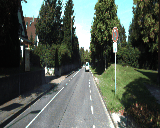

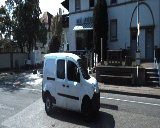

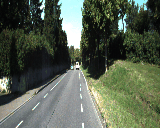

In [ ]:
# @title Plotting as Gif
import numpy as np
import imageio
import IPython.display as display
import tensorflow as tf

def visualize_sequence_as_gif(sequence):
    """
    Visualize a sequence of images (a video snippet) as an animated GIF with looping.
    The sequence is expected to be a tensor of shape [sequence_length, height, width, channels].
    """
    # Convert the TensorFlow tensor to a NumPy array
    sequence_np = sequence.numpy()

    # Normalize the images to [0, 255] and convert to uint8
    sequence_np = (sequence_np * 255).astype(np.uint8)

    # Create an animated GIF with looping
    with imageio.get_writer('sequence.gif', mode='I', duration=0.3, loop=0) as writer:
        for image in sequence_np:
            writer.append_data(image)

    # Load the GIF and display it
    with open('sequence.gif', 'rb') as f:
        display.display(display.Image(data=f.read(), format='png'))

# Fetch sequence from the dataset
for sequence in dataset_train.take(3):
    # Assuming the dataset yields batches of shape [batch_size, sequence_length, height, width, channels]
    # to visualize the first sequence in the batch
    visualize_sequence_as_gif(sequence[0][0])


Shape of the sequence: (10, 128, 160, 3)


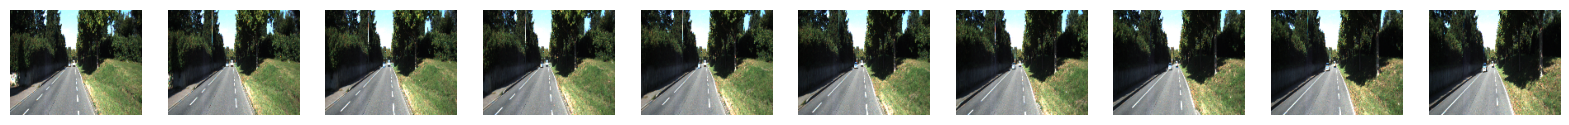

Shape of the sequence: (10, 128, 160, 3)


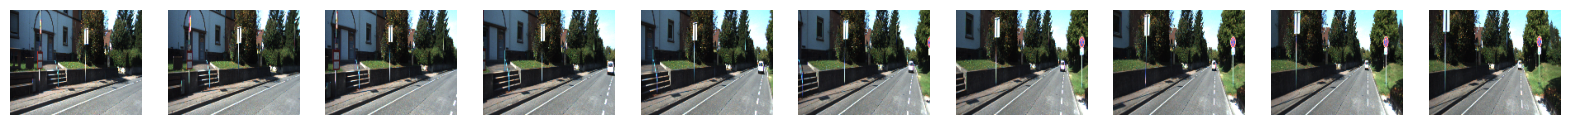

Shape of the sequence: (10, 128, 160, 3)


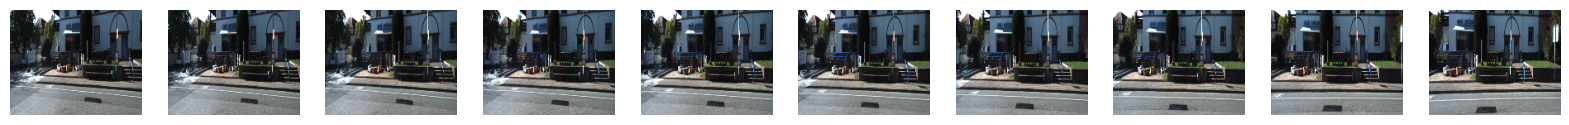

In [ ]:
# @title Plotting Sequences
# Extract batch from the training dataset
for sequences in dataset_train.take(3):
    first_sequence = sequences[0][0].numpy() * 255  # Convert the first sequence to a NumPy array for visualization

    # `first_sequence` shape is (sequence_length, image_height, image_width, channels)
    print("Shape of the sequence:", first_sequence.shape)

    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, sequence_length, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(first_sequence[i].astype("uint8"))
        ax.axis('off')
    plt.show()


In [ ]:
# @title Model Training
import tensorflow as tf
import tqdm
import os
import numpy as np
from itertools import islice # to keep the 125 iterations per epoch


# Set seeds for reproducibility
np.random.seed(42)

# Training parameters
nb_epoch = 20
batch_size = 4
samples_per_epoch = 500
N_seq_val = 100  # Number of sequences for validation

nt = 10  # number of timesteps used for sequences in training
n_channels, im_height, im_width = (3, 128, 160)
input_shape = (batch_size, nt, im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (1, 3, 3, 3) #first value doesnt matter, layer does not get build. Only for list comprehension simplicity.
Ahat_filt_sizes = (3, 3, 3, 3)
R_filt_sizes = (3, 3, 3, 3)
layer_loss_weights = np.array([1., 0., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNetModel(stack_sizes = stack_sizes, R_stack_sizes = R_stack_sizes, A_filt_sizes = A_filt_sizes, Ahat_filt_sizes = Ahat_filt_sizes, R_filt_sizes = R_filt_sizes,layer_loss_weights = layer_loss_weights, time_loss_weights= time_loss_weights)
prednet.build(input_shape)
prednet.summary()

train_generator = make_dataset(folder_paths=folder_paths_train,
                               sequence_length=nt, batch_size=batch_size,
                               target_size=(im_height, im_width),
                               shuffle=True,
                               shuffle_buffer_size=100,
                               sequence_start_mode='all',
                               output_mode='error',
                               N_seq=None)
val_generator = make_dataset(folder_paths=folder_paths_val,
                             sequence_length=nt,
                             batch_size=batch_size,
                             target_size=(im_height, im_width),
                             shuffle=False,
                             shuffle_buffer_size=100,
                             sequence_start_mode='all',
                             output_mode='error',
                             N_seq=N_seq_val) # does nothing since only 68 sequences in drive_1

#         #
#         # Train loop
#         #

steps_per_epoch = samples_per_epoch // batch_size

lr_schedule = lambda epoch: 0.001 if epoch < 30 else 0.0001
for epoch in range(nb_epoch):
     print(f"Epoch {epoch + 1}/{nb_epoch}")
     lr = lr_schedule(epoch)  # Calculate learning rate for this epoch
     prednet.optimizer.learning_rate = lr
     prednet.metric_loss.reset_states()
     with tqdm.tqdm(total=steps_per_epoch, position=0, leave=True) as pbar:
        for x, y_true in islice(train_generator, 0, steps_per_epoch): ###### basically just changed this
            prednet.train_step(x, y_true)
            pbar.update(1)

     # Validation Step
     train_loss = prednet.metric_loss.result()
     val_loss = prednet.validate(val_generator)

     # Print Results
     print(f"Train Loss: {train_loss.numpy()}")
     print(f"Validation Loss: {val_loss.numpy()}")


([<tf.Tensor 'pred_net/Reshape:0' shape=(4, 128, 160, 3) dtype=float32>, <tf.Tensor 'pred_net/Reshape_3:0' shape=(4, 64, 80, 48) dtype=float32>, <tf.Tensor 'pred_net/Reshape_6:0' shape=(4, 32, 40, 96) dtype=float32>, <tf.Tensor 'pred_net/Reshape_9:0' shape=(4, 16, 20, 192) dtype=float32>], [<tf.Tensor 'pred_net/Reshape_1:0' shape=(4, 128, 160, 3) dtype=float32>, <tf.Tensor 'pred_net/Reshape_4:0' shape=(4, 64, 80, 48) dtype=float32>, <tf.Tensor 'pred_net/Reshape_7:0' shape=(4, 32, 40, 96) dtype=float32>, <tf.Tensor 'pred_net/Reshape_10:0' shape=(4, 16, 20, 192) dtype=float32>], [<tf.Tensor 'pred_net/Reshape_2:0' shape=(4, 128, 160, 6) dtype=float32>, <tf.Tensor 'pred_net/Reshape_5:0' shape=(4, 64, 80, 96) dtype=float32>, <tf.Tensor 'pred_net/Reshape_8:0' shape=(4, 32, 40, 192) dtype=float32>, <tf.Tensor 'pred_net/Reshape_11:0' shape=(4, 16, 20, 384) dtype=float32>])
([<tf.Tensor 'pred_net/while/Placeholder_2:0' shape=(4, 128, 160, 3) dtype=float32>, <tf.Tensor 'pred_net/while/Placeholde

 48%|████▊     | 60/125 [59:01<1:02:18, 57.52s/it]

In [ ]:
# @title Model Evaluation
'''
Evaluate trained PredNet on KITTI sequences.
Calculates mean-squared error and plots predictions.
'''

import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


n_plot = 40
batch_size = 10
nt = 10


test_file = os.path.join(DATA_DIR, 'X_test.hkl')
test_sources = os.path.join(DATA_DIR, 'sources_test.hkl')


test_generator = SequenceGenerator(test_file, test_sources, nt, sequence_start_mode='unique') ## need Marvin's help adapting these two lines
X_test = test_generator.create_all()

X_hat = prednet.predict(X_test, batch_size)

# Compare MSE of PredNet predictions vs. using last frame.  Write results to prediction_scores.txt
mse_model = np.mean( (X_test[:, 1:] - X_hat[:, 1:])**2 )  # look at all timesteps except the first
mse_prev = np.mean( (X_test[:, :-1] - X_test[:, 1:])**2 )
if not os.path.exists(RESULTS_SAVE_DIR): os.mkdir(RESULTS_SAVE_DIR)
f = open(RESULTS_SAVE_DIR + 'prediction_scores.txt', 'w')
f.write("Model MSE: %f\n" % mse_model)
f.write("Previous Frame MSE: %f" % mse_prev)
f.close()

# Plot some predictions
aspect_ratio = float(X_hat.shape[2]) / X_hat.shape[3]
plt.figure(figsize = (nt, 2*aspect_ratio))
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)
plot_save_dir = os.path.join(RESULTS_SAVE_DIR, 'prediction_plots/')
if not os.path.exists(plot_save_dir): os.mkdir(plot_save_dir)
plot_idx = np.random.permutation(X_test.shape[0])[:n_plot]
for i in plot_idx:
    for t in range(nt):
        plt.subplot(gs[t])
        plt.imshow(X_test[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        plt.imshow(X_hat[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)

    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()